## Portfolio Optimization

# <span style="color:red">!!!!! Kann jemand hier einen besseren Text draften?</span>.

In this project, portfolio optimization on 9 selected stocks is conducted applying a Monte-Carlo-Simulation. The risk characteristics analyzed are standard deviation (volatility), Value at Risk, and Conditional Value at Risk.

The script is divided in several parts:
1. Import Libraries
2. Get and Prepare Relevant Stock Data
3. Transform Dataframe
4. Plot Stock Development Over Time
5. Monte-Carlo-Simulation
6. Plot Efficient Frontiers

##### 1. Import Libraries

In [1]:
# import relevant libraries

# for data collection
from datetime import datetime, timedelta
import yfinance as yf

# for data manipulation
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for normal distribution z-scores
from scipy.stats import norm

# timer for for-loops
from tqdm import tqdm

##### 2. Get and Prepare Relevant Stock Data

The relevant tickers for our 9 selected stocks (spread across markets and industries) are the following:

1. PetroChina Company Limited (0857.HK)
2. China Mobile Limited (0941.HK)
3. Tencent Holdings Limited (TCEHY)
4. General Electric Company (GE)
5. Apple Inc. (AAPL)
6. Walmart Inc. (WMT)
7. LVMH Moët Hennessy - Louis Vuitton, Société Européenne (MC.PA)
8. ASML Holding N.V. (ASML)
9. Siemens Aktiengesellschaft (SIE.DE)

# <span style="color:red">!!!!! Timespan nochmal absprechen</span>.

In [2]:
# define tickers and time span
tickers = ['0857.HK', '0941.HK', 'TCEHY', 'GE', 'AAPL', 'WMT', 'MC.PA', 'ASML', 'SIE.DE']
start_date = datetime(2010, 1, 1)
end_date = datetime(2019, 12, 31)

# <span style="color:red">!!!!! Wir arbeiten mit Adjusted Closing Prices wie besprochen, passt?</span>.

In [3]:
# create dataframe with all data
stocks = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date)
    # adjusted closing price because it accounts for dividends, stock splits, etc.
    stocks[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# check dataframe
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2452 entries, 2010-01-04 to 2019-12-30
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0857.HK  2452 non-null   float64
 1   0941.HK  2452 non-null   float64
 2   TCEHY    2390 non-null   float64
 3   GE       2391 non-null   float64
 4   AAPL     2391 non-null   float64
 5   WMT      2391 non-null   float64
 6   MC.PA    2447 non-null   float64
 7   ASML     2391 non-null   float64
 8   SIE.DE   2430 non-null   float64
dtypes: float64(9)
memory usage: 191.6 KB


In [5]:
# check dimensions
stocks.shape

(2452, 9)

In [6]:
# check first entries
stocks.head()

,0857.HK,0941.HK,TCEHY,GE,AAPL,WMT,MC.PA,ASML,SIE.DE
Date,,,,,,,,,
2010-01-04,5.111075,35.461399,NaN,68.035370,6.487535,39.871315,60.207401,24.071445,39.892433
2010-01-05,5.413667,35.755482,4.053075,68.387619,6.498749,39.474293,59.924343,24.258965,39.916805
2010-01-06,5.523702,35.976051,4.080387,68.035370,6.395380,39.386078,60.505775,24.481205,40.063049
2010-01-07,5.501695,35.902527,3.914696,71.558197,6.383555,39.408127,61.194302,23.800594,40.538307
2010-01-08,5.545708,36.490688,3.967497,73.099457,6.425995,39.209625,62.020538,23.231100,40.794228


In [7]:
# change column names to make it easier to understand
stocks.columns = \
['PetroChina Company Limited', \
 'China Mobile Limited', \
 'Tencent Holdings Limited', \
 'General Electric Company', \
 'Apple Inc.', \
 'Walmart Inc.', \
 'LVMH Moët Hennessy (SE)', \
 'ASML Holding N.V.', \
 'Siemens Aktiengesellschaft']

# <span style="color:red">!!!!! Trading days entsprechen sind deutlich niedriger als 252, welche Annahme machen wir?</span>.

In [8]:
# check how many trading days there are per year
entries_per_year = stocks.resample('Y').size()
print(entries_per_year, '\n')
print('The mean amount of trading days is: ', np.mean(entries_per_year))

Date
2010-12-31    236
2011-12-31    246
2012-12-31    246
2013-12-31    245
2014-12-31    247
2015-12-31    247
2016-12-31    247
2017-12-31    247
2018-12-31    246
2019-12-31    245
Freq: A-DEC, dtype: int64 

The mean amount of trading days is:  245.2


# <span style="color:red">!!!!! Nur zur Veranschaulichung wie viele NAs im Datensatz sind</span>.

In [9]:
stocks.isna().sum()

PetroChina Company Limited     0
China Mobile Limited           0
Tencent Holdings Limited      62
General Electric Company      61
Apple Inc.                    61
Walmart Inc.                  61
LVMH Moët Hennessy (SE)        5
ASML Holding N.V.             61
Siemens Aktiengesellschaft    22
dtype: int64

# <span style="color:red">!!!!! Annahme siehe oben</span>.

For further processing 245 trading days per year are assumed.

In [10]:
# annualizing factor
days_per_year = 252

In [11]:
# save dataframe to csv
stocks.to_csv('stocks_data.csv')

In [12]:
# load dataframe
# stocks = pd.read_csv('stocks_data.csv', index_col=0)

##### 3. Transform Dataframe

To make a comparison possible the stocks are transformed to percentage returns.

In [13]:
# calculate log returns (advantage: additivity of logs)
log_returns = np.log(stocks/stocks.shift(1)).dropna() # drop first row (=NA)

# <span style="color:red">!!!!! Nur zur Veranschaulichung wie viele Datenpunkte verloren gehen</span>.

In [14]:
# check how many trading days there are per year
entries_per_year = log_returns.resample('Y').size()
print(entries_per_year, '\n')
print('The mean amount of trading days is: ', np.mean(entries_per_year))

Date
2010-12-31    221
2011-12-31    231
2012-12-31    226
2013-12-31    227
2014-12-31    229
2015-12-31    233
2016-12-31    230
2017-12-31    235
2018-12-31    229
2019-12-31    226
Freq: A-DEC, dtype: int64 

The mean amount of trading days is:  228.7


In [15]:
# save dataframe to csv
log_returns.to_csv('log_returns_data.csv')

In [16]:
# load dataframe
# log_returns = pd.read_csv('log_returns_data.csv', index_col=0)

In [17]:
# check the transformed dataframe
log_returns.head()

,PetroChina Company Limited,China Mobile Limited,Tencent Holdings Limited,General Electric Company,Apple Inc.,Walmart Inc.,LVMH Moët Hennessy (SE),ASML Holding N.V.,Siemens Aktiengesellschaft
Date,,,,,,,,,
2010-01-06,0.020122,0.006150,0.006716,-0.005164,-0.016034,-0.002237,0.009656,0.009119,0.003657
2010-01-07,-0.003992,-0.002046,-0.041454,0.050483,-0.001851,0.000560,0.011315,-0.028195,0.011793
2010-01-08,0.007968,0.016249,0.013398,0.021310,0.006626,-0.005050,0.013412,-0.024219,0.006293
2010-01-11,0.009871,0.005359,0.019542,0.009593,-0.008860,0.016366,0.007741,-0.021454,0.002536
2010-01-12,-0.005911,0.023764,-0.017708,0.000596,-0.011440,0.009546,-0.029185,0.001526,-0.012292


##### 4. Plot Stock Development Over Time

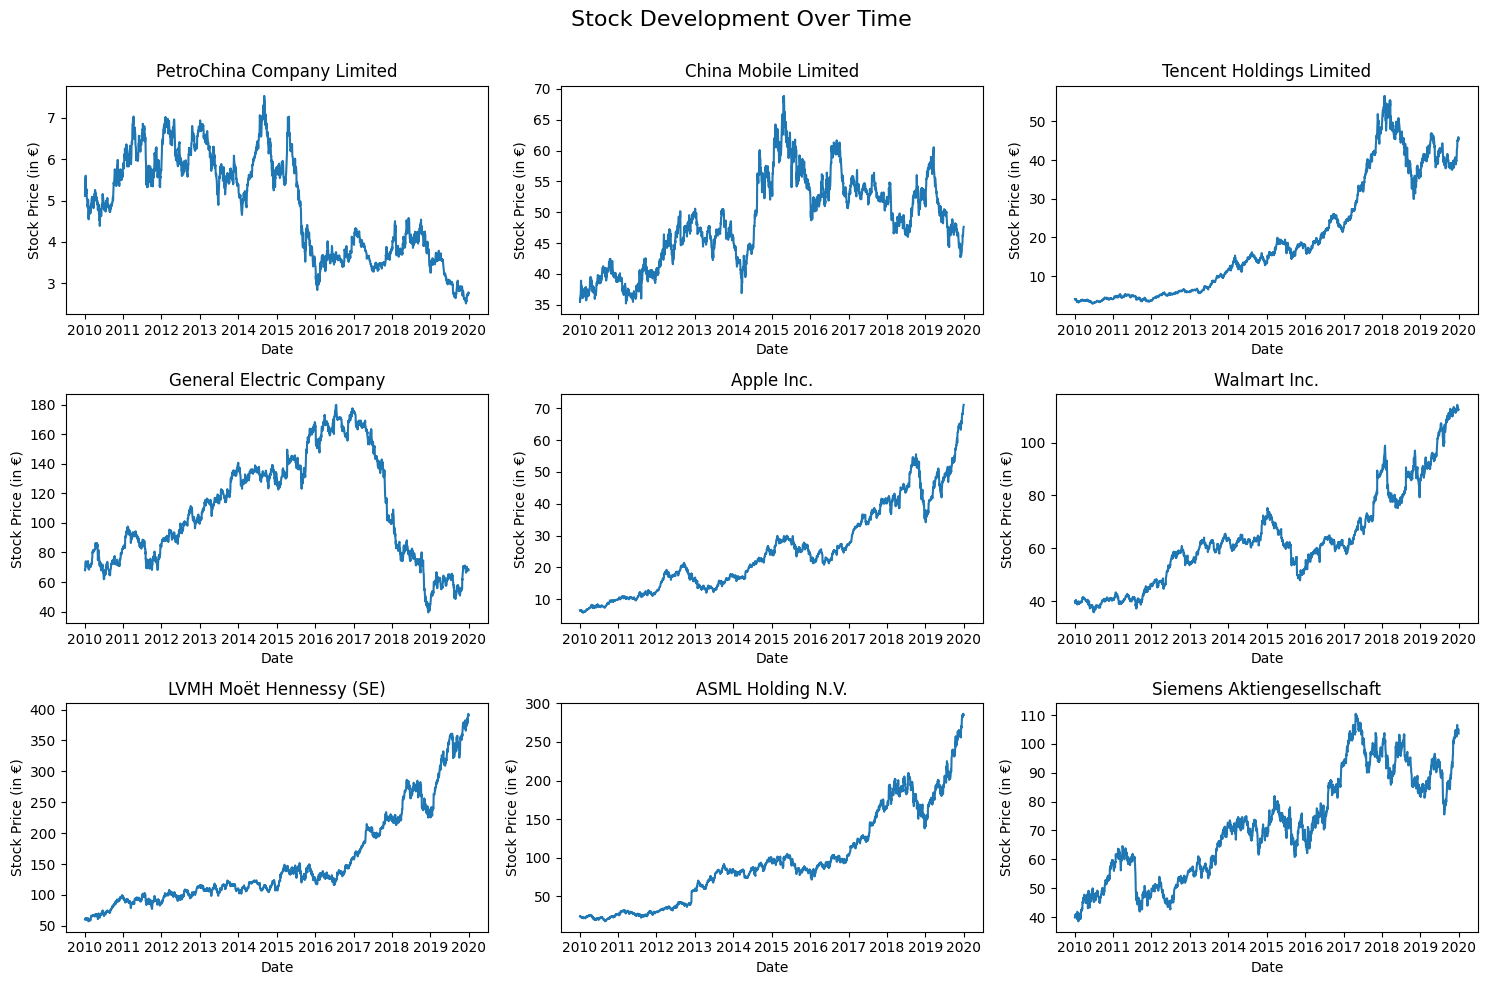

In [18]:
# create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# loop through stocks and plot each in a separate subplot
for i in range(3):
    for j in range(3):
        stock_name = stocks.columns[i*3+j]
        sns.lineplot(data=stocks[stock_name], ax=axes[i, j])
        x_scaler = int(stocks.iloc[:,[i*3+j]].max())*1.1
        axes[i,j].set_title(stock_name)
        axes[i,j].set_xlabel('Date')
        axes[i,j].set_ylabel('Stock Price (in €)')

# title for the entire set of subplots
fig.suptitle('Stock Development Over Time \n', fontsize=16)

# adjust subplot layout
plt.tight_layout()

# save plot
plt.savefig('Stocks_Development.png')

# show the plot
plt.show()

##### 5. Monte Carlo Simulation

In [19]:
# set all input variables

# set seed for reproducibility
np.random.seed(42)

# number of stocks
num_stocks = stocks.shape[1]

# number of simulations
num_sim = 10000

# confidence level for VaR
confidence_level = 0.95

# <span style="color:red">!!!!! Annualize by multiplying with number of trading days per year, hätte nein gesagt, da wir Daily Log Returns haben</span>.

In [20]:
# calculate the covariane matrix
cov_matrix = log_returns.cov()

In [21]:
# plot the covariance matrix
cov_matrix

,PetroChina Company Limited,China Mobile Limited,Tencent Holdings Limited,General Electric Company,Apple Inc.,Walmart Inc.,LVMH Moët Hennessy (SE),ASML Holding N.V.,Siemens Aktiengesellschaft
PetroChina Company Limited,0.000294,0.000105,0.000091,0.000041,0.000030,0.000007,0.000071,0.000034,0.000059
China Mobile Limited,0.000105,0.000165,0.000060,0.000013,0.000014,0.000007,0.000041,0.000018,0.000031
Tencent Holdings Limited,0.000091,0.000060,0.000457,0.000105,0.000110,0.000047,0.000129,0.000163,0.000101
General Electric Company,0.000041,0.000013,0.000105,0.000290,0.000087,0.000044,0.000094,0.000115,0.000096
Apple Inc.,0.000030,0.000014,0.000110,0.000087,0.000277,0.000039,0.000084,0.000132,0.000069
Walmart Inc.,0.000007,0.000007,0.000047,0.000044,0.000039,0.000120,0.000037,0.000051,0.000033
LVMH Moët Hennessy (SE),0.000071,0.000041,0.000129,0.000094,0.000084,0.000037,0.000279,0.000127,0.000152
ASML Holding N.V.,0.000034,0.000018,0.000163,0.000115,0.000132,0.000051,0.000127,0.000409,0.000107
Siemens Aktiengesellschaft,0.000059,0.000031,0.000101,0.000096,0.000069,0.000033,0.000152,0.000107,0.000207


<AxesSubplot:>

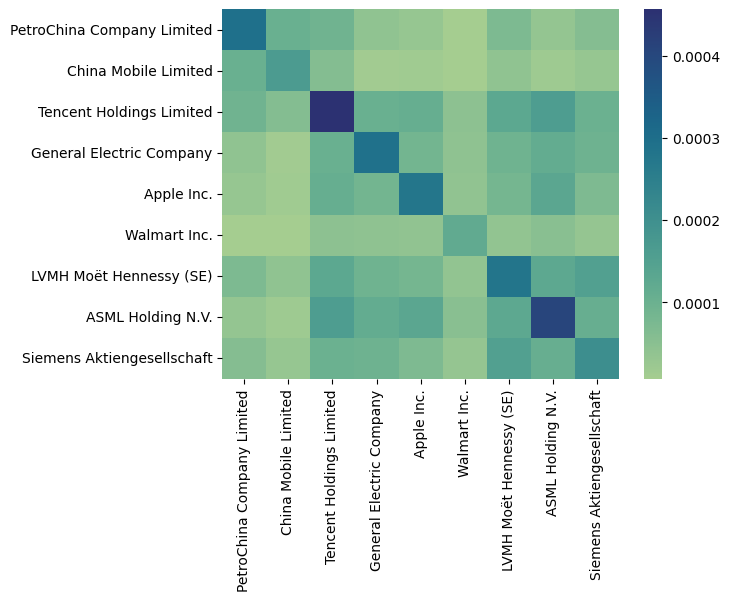

In [22]:
# for better understanding plot as heatmap
sns.heatmap(cov_matrix, cmap="crest")

In [23]:
# save all risk measures in these numpy arrays
weights_all = np.zeros((num_sim,len(stocks.columns)))
expected_return_daily = np.zeros(num_sim)
expected_return_annually = np.zeros(num_sim)
sd_daily = np.zeros(num_sim)
sd_annually = np.zeros(num_sim)
var_daily = np.zeros(num_sim)
cvar_daily = np.zeros(num_sim)

# <span style="color:red">!!!!! Wäre ganz geil, wenn jemand die Formeln nochmal checken könnte</span>.

In [24]:
for simulations in tqdm(range(num_sim)):
    '''
    simulate num_sim times different, random weight portfolios and calculate the respective risk metrics
    '''
    
    # weights
    # generate for each iteration as many random values as stocks
    random_values = np.random.rand(num_stocks)
    # normalize random values to sum up to 1
    weights = random_values / random_values.sum()

    # create a temporary df to apply weights on the daily log returns
    log_returns_weights = log_returns.copy()
    # apply weights on individual daily returns
    for i in range(log_returns.shape[1]):
        log_returns_weights.iloc[:,i] *= weights[i]
    # combine to only one numpy array
    log_returns_aggregated = log_returns_weights.sum(axis=1)

    # calculate all risk measures for all simulated portfolios and add them to their respective numpy array
    # all measures here are in log-scale
    # daily and annually risk measures

    # weights
    weights_all[simulations,:] = weights
    # expected return daily
    expected_return_daily[simulations] = np.mean(log_returns_aggregated)
    # expected return annually
    expected_return_annually[simulations] = expected_return_daily[simulations]*days_per_year
    # standard deviation (volatility) daily
    sd_daily[simulations] = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))
    # standard deviation (volatility) annually
    sd_annually[simulations] = sd_daily[simulations]*np.sqrt(days_per_year) 
    # Value at Risk (VaR) daily
    var_daily[simulations] = np.percentile(log_returns_aggregated, 1-confidence_level)
    # Conditional Value at Risk (CVaR) daily
    # find losses below VaR
    losses = [r for r in log_returns_aggregated if r < var_daily[simulations]]
    cvar_daily[simulations] = np.mean(losses)
    
    # convert risk metrics back to percentages
    expected_return_daily[simulations] = np.exp(expected_return_daily[simulations]) - 1
    expected_return_annually[simulations] = np.exp(expected_return_annually[simulations]) - 1
    sd_daily[simulations] = np.exp(sd_daily[simulations]) - 1
    sd_annually[simulations] = np.exp(sd_annually[simulations]) - 1
    var_daily[simulations] = np.exp(var_daily[simulations]) - 1
    cvar_daily[simulations] = np.exp(cvar_daily[simulations]) - 1

100%|██████████| 10000/10000 [00:56<00:00, 176.03it/s]


##### 6. Plot Efficient Frontier

###### 6.1. Plot Efficient Frontier (Expected Return (Annually) vs. Volatility (Annually))

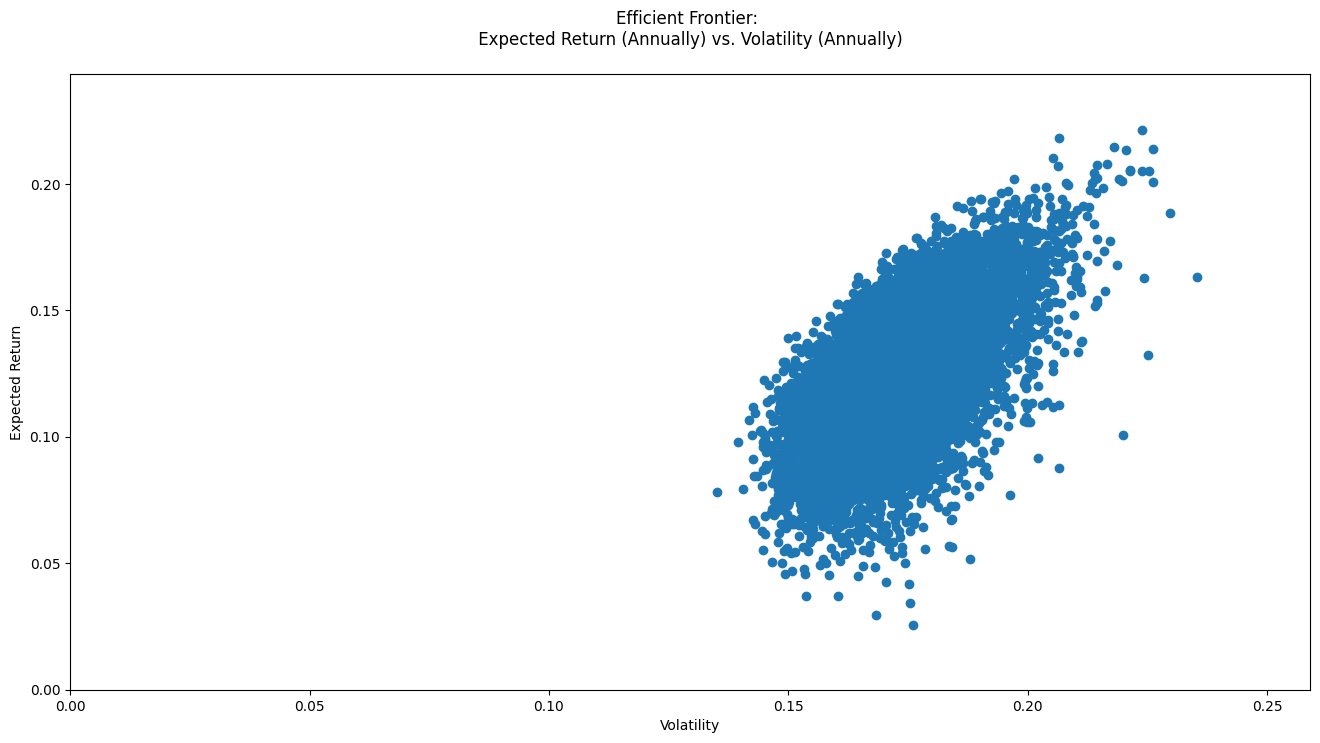

In [25]:
# plot efficient frontier (expected return (annually) vs. volatility (annually))

# define figure
plt.figure(figsize=(16,8))

# plot the variables
plt.scatter(sd_annually,expected_return_annually)

# set axes ranges
plt.ylim([0,max(expected_return_annually)*1.1])
plt.xlim([0,max(sd_annually)*1.1])

# title for plot and axes
plt.title('Efficient Frontier: \n Expected Return (Annually) vs. Volatility (Annually) \n')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')

# plot
plt.show()

###### 6.2. Plot Efficient Frontier (Expected Return (Annually) vs. Value at Risk (Daily))

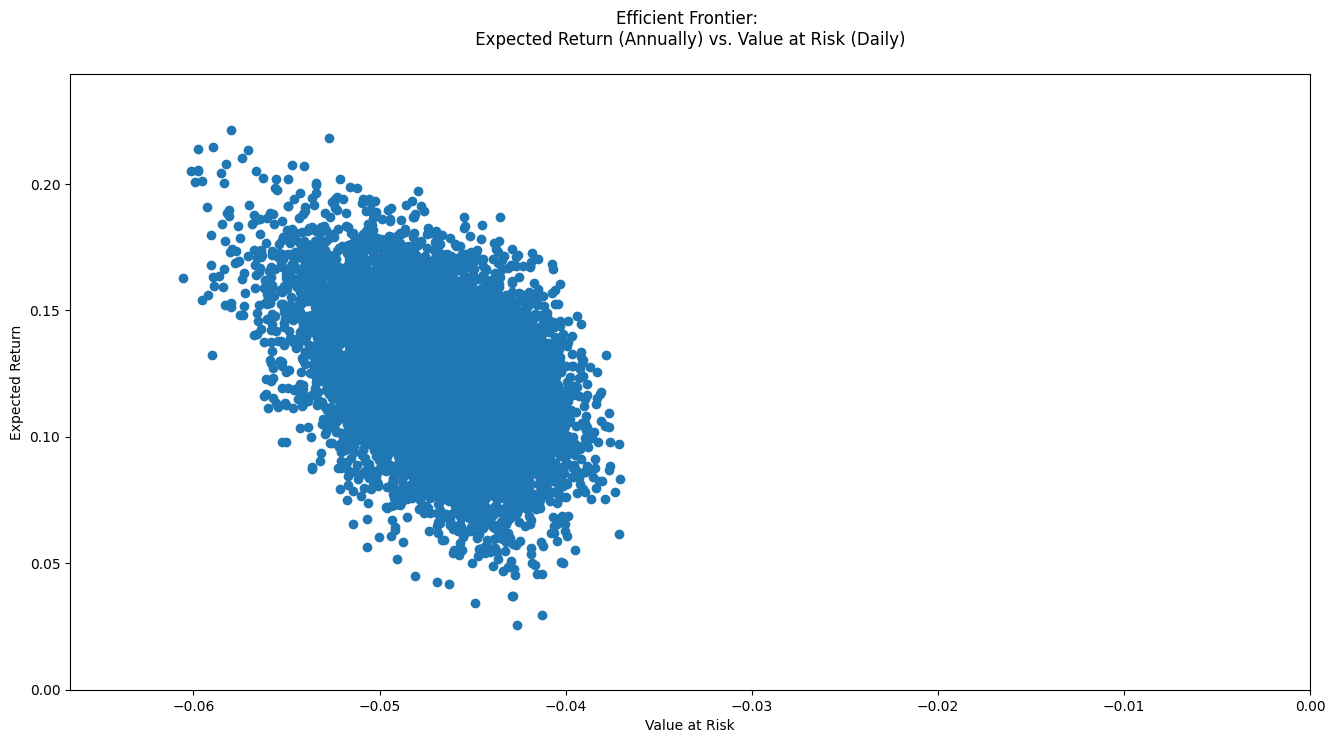

In [26]:
# plot efficient frontier (expected return (annually) vs. VaR (daily))

# define figure
plt.figure(figsize=(16,8))

# plot the variables
plt.scatter(var_daily,expected_return_annually)

# set axes ranges
plt.ylim([0,max(expected_return_annually)*1.1])
plt.xlim([min(var_daily)*1.1,0])

# title for plot and axes
plt.title('Efficient Frontier: \n Expected Return (Annually) vs. Value at Risk (Daily) \n')
plt.xlabel('Value at Risk')
plt.ylabel('Expected Return')

# plot
plt.show()

###### 6.3. Plot Efficient Frontier (Expected Return (Annually) vs. Conditional Value at Risk (Daily))

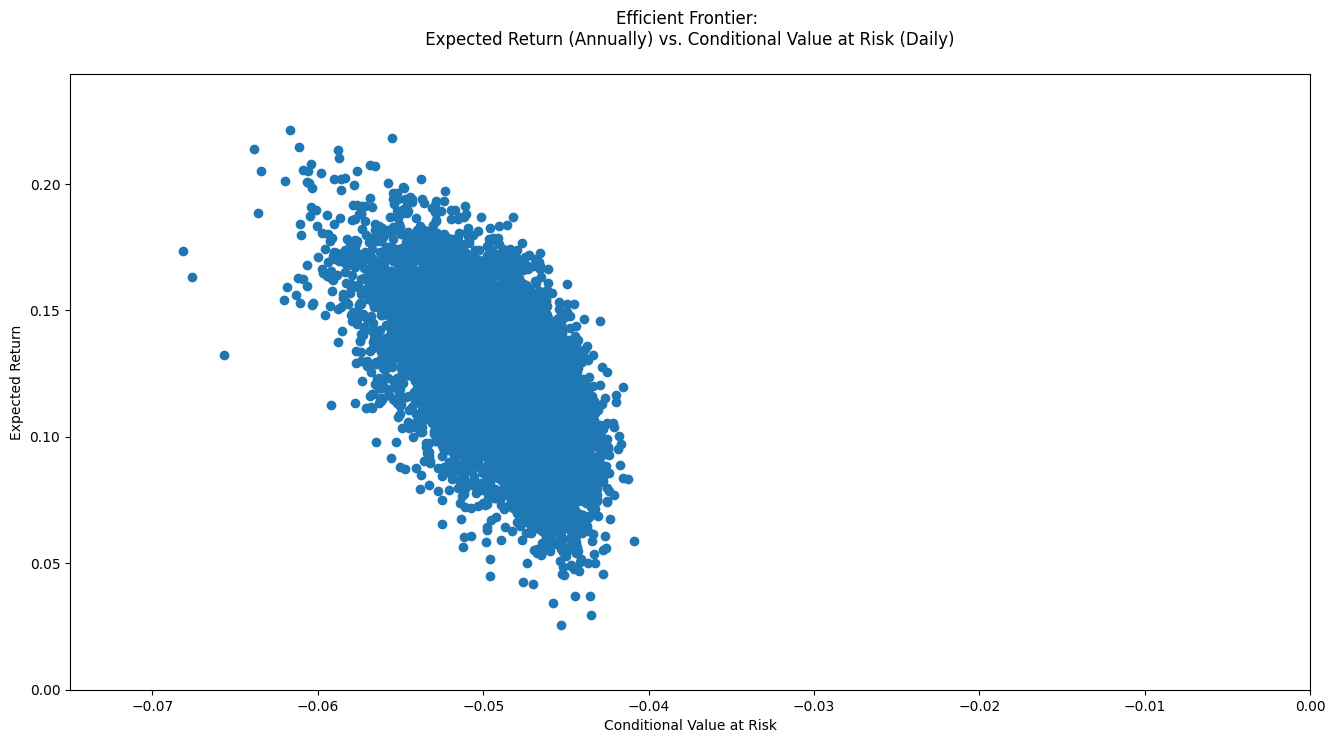

In [27]:
# plot efficient frontier (expected return (annually) vs. CVaR (daily))

# define figure
plt.figure(figsize=(16,8))

# plot the variables
plt.scatter(cvar_daily,expected_return_annually)

# set axes ranges
plt.ylim([0,max(expected_return_annually)*1.1])
plt.xlim([min(cvar_daily)*1.1,0])

# title for plot and axes
plt.title('Efficient Frontier: \n Expected Return (Annually) vs. Conditional Value at Risk (Daily) \n')
plt.xlabel('Conditional Value at Risk')
plt.ylabel('Expected Return')

# plot
plt.show()